# MLP 1 mes

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split 
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import optuna
import matplotlib.pyplot as plt
from operator import itemgetter
import re

# This is for the final plot
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

# Setting up the Pytorch device
device = torch.device('cpu') # use the cpu
# Setting up the the batch size
batch_size = 256

## Preparando el dataset


In [2]:
# Reading the data
data = pd.read_csv('../../../Datos/processed data.csv')
data['fecha'] = pd.to_datetime(data['fecha'])
print(data.dtypes)
data

fecha               datetime64[ns]
ipc                        float64
rem                        float64
expec_utdt                 float64
emae                       float64
badlar_1                   float64
badlar_2                   float64
badlar_3                   float64
badlar_4                   float64
badlar_5                   float64
base_monetaria_1           float64
base_monetaria_2           float64
base_monetaria_3           float64
base_monetaria_4           float64
base_monetaria_5           float64
reservas_1                 float64
reservas_2                 float64
reservas_3                 float64
reservas_4                 float64
reservas_5                 float64
dolar_mayor_1              float64
dolar_mayor_2              float64
dolar_mayor_3              float64
dolar_mayor_4              float64
dolar_mayor_5              float64
dolar_informal_1           float64
dolar_informal_2           float64
dolar_informal_3           float64
dolar_informal_4    

,fecha,ipc,rem,expec_utdt,emae,badlar_1,badlar_2,badlar_3,badlar_4,badlar_5,...,dolar_mayor_1,dolar_mayor_2,dolar_mayor_3,dolar_mayor_4,dolar_mayor_5,dolar_informal_1,dolar_informal_2,dolar_informal_3,dolar_informal_4,dolar_informal_5
0,2002-03-01,4.0,0.000000,0.000000,0.0,21.5000,19.5000,14.5000,20.6250,0.0000,...,2.370000,2.340000,2.320000,2.380000,2.430000,2.185,2.110,2.11,2.13,2.210
1,2002-04-01,10.4,0.000000,0.000000,0.0,52.0625,47.3750,55.4375,65.0000,35.0000,...,2.890000,2.900000,2.800000,2.670000,2.700000,2.915,2.955,2.83,2.80,2.775
2,2002-05-01,4.0,0.000000,0.000000,0.0,138.4375,115.8750,141.1875,160.1250,189.1875,...,3.040000,3.160000,3.160000,3.170000,3.190000,3.135,3.190,3.20,3.22,3.240
3,2002-06-01,3.6,0.000000,0.000000,0.0,119.3750,147.6875,109.5625,86.1250,99.1875,...,3.590000,3.610000,3.630000,3.640000,3.630000,3.640,3.650,3.66,3.69,3.700
4,2002-07-01,3.2,0.000000,0.000000,0.0,84.1875,94.3750,113.3750,115.6250,94.0000,...,3.790000,3.690000,3.580000,3.560000,3.570000,3.820,3.690,3.63,3.59,3.630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2020-12-01,4.0,3.652041,44.481538,127.1,34.3750,34.3125,34.1875,34.0625,34.2500,...,81.400002,81.480003,81.559998,81.650002,82.050003,150.000,150.000,148.00,147.00,146.000
226,2021-01-01,4.0,3.852123,42.854528,132.1,34.0625,34.3125,33.9375,33.8125,34.1250,...,84.699997,84.800003,84.900002,85.000000,85.110001,162.000,157.000,157.00,159.00,158.000
227,2021-02-01,3.6,3.803133,44.139414,133.4,34.1875,34.1875,34.0000,34.1875,34.0625,...,87.610001,87.699997,87.809998,87.910004,88.010002,150.500,150.500,150.50,147.50,148.500
228,2021-03-01,4.8,3.530524,45.238070,132.6,34.0625,34.0625,34.1875,33.8750,33.8750,...,90.089996,90.160004,90.220001,90.300003,90.370003,143.500,142.500,142.50,141.50,141.500


### Normalizando las variables de frecuencia mensual

In [3]:
# Normalizing the monthly variables
monthly_cols = ['rem', 'expec_utdt', 'emae']
for i in range(len(monthly_cols)):
    col = monthly_cols[i]
    scaler = MinMaxScaler()
    data[col] = scaler.fit_transform(data[col].to_numpy(dtype='float32').reshape(-1, 1))
    
# The ipc normalization is done separately because we might need to reverse the scaling
ipc_scaler = MinMaxScaler()
data['ipc'] = ipc_scaler.fit_transform(data['ipc'].to_numpy(dtype='float32').reshape(-1, 1))
data

,fecha,ipc,rem,expec_utdt,emae,badlar_1,badlar_2,badlar_3,badlar_4,badlar_5,...,dolar_mayor_1,dolar_mayor_2,dolar_mayor_3,dolar_mayor_4,dolar_mayor_5,dolar_informal_1,dolar_informal_2,dolar_informal_3,dolar_informal_4,dolar_informal_5
0,2002-03-01,0.407407,0.000000,0.000000,0.000000,21.5000,19.5000,14.5000,20.6250,0.0000,...,2.370000,2.340000,2.320000,2.380000,2.430000,2.185,2.110,2.11,2.13,2.210
1,2002-04-01,1.000000,0.000000,0.000000,0.000000,52.0625,47.3750,55.4375,65.0000,35.0000,...,2.890000,2.900000,2.800000,2.670000,2.700000,2.915,2.955,2.83,2.80,2.775
2,2002-05-01,0.407407,0.000000,0.000000,0.000000,138.4375,115.8750,141.1875,160.1250,189.1875,...,3.040000,3.160000,3.160000,3.170000,3.190000,3.135,3.190,3.20,3.22,3.240
3,2002-06-01,0.370370,0.000000,0.000000,0.000000,119.3750,147.6875,109.5625,86.1250,99.1875,...,3.590000,3.610000,3.630000,3.640000,3.630000,3.640,3.650,3.66,3.69,3.700
4,2002-07-01,0.333333,0.000000,0.000000,0.000000,84.1875,94.3750,113.3750,115.6250,94.0000,...,3.790000,3.690000,3.580000,3.560000,3.570000,3.820,3.690,3.63,3.59,3.630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2020-12-01,0.407407,0.635501,0.938103,0.752516,34.3750,34.3125,34.1875,34.0625,34.2500,...,81.400002,81.480003,81.559998,81.650002,82.050003,150.000,150.000,148.00,147.00,146.000
226,2021-01-01,0.407407,0.670317,0.903790,0.782120,34.0625,34.3125,33.9375,33.8125,34.1250,...,84.699997,84.800003,84.900002,85.000000,85.110001,162.000,157.000,157.00,159.00,158.000
227,2021-02-01,0.370370,0.661792,0.930888,0.789816,34.1875,34.1875,34.0000,34.1875,34.0625,...,87.610001,87.699997,87.809998,87.910004,88.010002,150.500,150.500,150.50,147.50,148.500
228,2021-03-01,0.481482,0.614355,0.954058,0.785080,34.0625,34.0625,34.1875,33.8750,33.8750,...,90.089996,90.160004,90.220001,90.300003,90.370003,143.500,142.500,142.50,141.50,141.500


### Normalizando las variables de frecuencia diaria

In [4]:
def normalize_daily_vars(daily_cols, df):
    """This function normalizes the variables that have a daily frequency"""
    # List that will contain lists of column names
    col_names = []
    # Looping over the input list
    for i in daily_cols:
        # List that contains the columns with daily variables
        cols = [f"{i}_{ii}" for ii in range(1, 6)]
        col_names.append(cols)
    # Looping over the list that contains all the daily variables
    for i in col_names:
        scaler = MinMaxScaler()
        df[i] = scaler.fit_transform(df[i])
    return df

daily_cols = ['badlar', 'base_monetaria', 'reservas', 'dolar_mayor', 'dolar_informal']
data = normalize_daily_vars(daily_cols, data)
data

,fecha,ipc,rem,expec_utdt,emae,badlar_1,badlar_2,badlar_3,badlar_4,badlar_5,...,dolar_mayor_1,dolar_mayor_2,dolar_mayor_3,dolar_mayor_4,dolar_mayor_5,dolar_informal_1,dolar_informal_2,dolar_informal_3,dolar_informal_4,dolar_informal_5
0,2002-03-01,0.407407,0.000000,0.000000,0.000000,0.146442,0.125373,0.094281,0.121606,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2002-04-01,1.000000,0.000000,0.000000,0.000000,0.369526,0.315565,0.386953,0.401023,0.185002,...,0.005786,0.006226,0.005332,0.003222,0.003000,0.004484,0.005285,0.004619,0.004271,0.003627
2,2002-05-01,0.407407,0.000000,0.000000,0.000000,1.000000,0.782942,1.000000,1.000000,1.000000,...,0.007455,0.009116,0.009331,0.008777,0.008444,0.005835,0.006755,0.006992,0.006948,0.006611
3,2002-06-01,0.370370,0.000000,0.000000,0.000000,0.860858,1.000000,0.773905,0.534042,0.524281,...,0.013575,0.014119,0.014552,0.013998,0.013332,0.008937,0.009632,0.009943,0.009945,0.009564
4,2002-07-01,0.333333,0.000000,0.000000,0.000000,0.604015,0.636247,0.801162,0.719795,0.496862,...,0.015801,0.015008,0.013997,0.013110,0.012665,0.010042,0.009882,0.009750,0.009307,0.009115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2020-12-01,0.407407,0.635501,0.938103,0.752516,0.240420,0.226439,0.235031,0.206218,0.181037,...,0.879381,0.879822,0.880249,0.880680,0.884568,0.907871,0.924948,0.935852,0.923504,0.922973
226,2021-01-01,0.407407,0.670317,0.903790,0.782120,0.238139,0.226439,0.233244,0.204644,0.180377,...,0.916101,0.916732,0.917352,0.917898,0.918565,0.981574,0.968729,0.993585,1.000000,1.000000
227,2021-02-01,0.370370,0.661792,0.930888,0.789816,0.239051,0.225586,0.233691,0.207005,0.180046,...,0.948481,0.948972,0.949678,0.950228,0.950783,0.910942,0.928076,0.951889,0.926691,0.939020
228,2021-03-01,0.481482,0.614355,0.954058,0.785080,0.238139,0.224733,0.235031,0.205037,0.179055,...,0.976077,0.976320,0.976450,0.976780,0.977003,0.867948,0.878041,0.900571,0.888443,0.894088


### Separando variables explicadas y explicativas

In [5]:
# Extracting the vector of the objective variable and the matrix of features
# And converting them to numpy arrays
y = data['ipc'].to_numpy(dtype='float32').reshape(230, 1) # avoid a UserWarning and potential errors
X = data.drop(columns=['ipc', 'fecha']).to_numpy(dtype='float32')

### Haciendo el train-test split y transformando los datos a Pytorch tensors

In [6]:
# Doing the test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

In [7]:
# Transforming the data to Pytorch Tensors
X_train = torch.from_numpy(X_train).to(device) 
X_test = torch.from_numpy(X_test).to(device)
y_train = torch.from_numpy(y_train).to(device) 
y_test = torch.from_numpy(y_test).to(device)

In [8]:
# Preparing the dataloader for the model
def load_data(data_arrays, batch_size):
    """This function creates a dataloader object from the data """
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=False)

## Seleccion del Modelo
### Definiendo la busqueda de hiperparametros

In [9]:
# Defining steps to search hyperparameters
def define_model(trial):
    """This function defines the structure of the model used"""
    n_layers = trial.suggest_int("n_layers", 1, 2) # Suggest n_layers
    layers = []
    in_feat = X.shape[1]

    for i in range(n_layers):
        out_feat = trial.suggest_int(f"layer_width_{i}", 8, 64) # Suggest layer_width
        layers.append(nn.Linear(in_feat, out_feat))
        # Suggest activation function
        act_func_list = ["ReLU", "Sigmoid", "Tanh"]
        act_func_trial = trial.suggest_categorical(f"act_function_{i}", act_func_list)
        activation_func = getattr(nn, act_func_trial)()
        layers.append(activation_func)
        # Suggest droput
        p = trial.suggest_float(f"dropout_layer_{i}", 0.0, 0.3)
        layers.append(nn.Dropout(p))
        in_feat = out_feat

    layers.append(nn.Linear(in_feat, 1))
    return nn.Sequential(*layers)

def init_weights(model, trial):
    """This function initializes the model's weights"""
    init_w = trial.suggest_categorical("init_w", ["normal_", "xavier_normal_"])
    if model == nn.Linear:
        getattr(nn.init, init_w)(model.weight, mean=0, std=0.01)
        nn.init.zeros_(model.bias)
       
def get_optim(model, trial):
    optim_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-2, 1)
    regul = trial.suggest_float("weight_decay", 0.0, 0.0)
    optim = getattr(torch.optim, optim_name)(model.parameters(), lr, weight_decay=regul)
    return optim

def train_model(optim, model, train_data, criterion, n_epochs):
    """This function trains the model and prints the loss for each epoch"""
    # Setting the model to train mode
    model.train()
    # Looping over the epochs
    for i in range(n_epochs): 
        # Making epoch global so Optuna works
        global epoch
        epoch = i  
        # Looping over the batches
        for X, y in train_data:
            # Training
            optim.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optim.step()

def test_model(model, test_data):
    """This models makes predictions over the batches of the test set and returns the
       average MSE"""
    # Accumulator for the loss function
    total_loss = 0
    # Counter for n_batches
    i = 0
    model.eval()
    with torch.no_grad():
        # Looping over the batches in the dataloader
        for X, y in test_data:
            # Get model predictions
            y_pred = model(X)
            # Calculate the loss over the batch
            loss = F.mse_loss(y_pred, y)
            # Add the loss to the accumulator
            total_loss += loss.item()
            # Count 
            i += 1
    return total_loss / i

def get_model_preds(model, X):
    """This function returns the vector of predictions for the features X as a 
       numpy array"""
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
    return y_pred

In [10]:
def objective(trial, n_epochs):
    """This is the objective function to optimize with Optuna """
    # Define the model and add manual seed to improve reproductibility
    torch.manual_seed(10)
    model = define_model(trial).to(device)
    # Initialize the model's weights
    init_weights(model, trial)
    # Define the optimizer
    optim = get_optim(model, trial)
    # Load the training data
    train_data = load_data((X_train, y_train), batch_size) 
    # Train the model
    train_model(optim, model, train_data, nn.MSELoss(), n_epochs) 
    # Load the test data
    test_data = load_data((X_test, y_test), batch_size)
    # Measuring model accuracy on the test set
    accuracy = test_model(model, test_data)
    
    trial.report(accuracy, epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy

#### Haciendo el grid search de n_epochs

In [11]:
# Doing a grid search to find the best n_epochs
def try_n_epochs(epochs_list, n_trials):
    """This function takes a list containing n_epochs and returns one dict containing the mse and 
       another containing params for each n_epochs"""
    # Defining dicts to store data
    epochs_mse = {}
    epochs_params = {} 
    # Setting up some Optuna parameters
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Stop optuna from logging after each trial
    sampler = optuna.samplers.TPESampler(seed=10) # Defining the seed so results are more reproductible 
    # Looping over epochs_list
    for n_epochs in epochs_list:
        # Create the study and optimize
        study = optuna.create_study(direction='minimize', sampler=sampler)
        study.optimize(lambda trial: objective(trial, n_epochs), n_trials=n_trials)
        # Save the data from the best trial
        trial = study.best_trial
        epochs_mse[n_epochs] = trial.value
        epochs_params[n_epochs] = trial.params.items()
        print(f'Study for {n_epochs} epochs finished')

    return epochs_mse, epochs_params

epochs_list = [i for i in range(101, 200, 1)]
epochs_mse, epochs_hyperpar = try_n_epochs(epochs_list, 10)

Study for 101 epochs finished
Study for 102 epochs finished
Study for 103 epochs finished
Study for 104 epochs finished
Study for 105 epochs finished
Study for 106 epochs finished
Study for 107 epochs finished
Study for 108 epochs finished
Study for 109 epochs finished
Study for 110 epochs finished
Study for 111 epochs finished
Study for 112 epochs finished
Study for 113 epochs finished
Study for 114 epochs finished
Study for 115 epochs finished
Study for 116 epochs finished
Study for 117 epochs finished
Study for 118 epochs finished
Study for 119 epochs finished
Study for 120 epochs finished
Study for 121 epochs finished
Study for 122 epochs finished
Study for 123 epochs finished
Study for 124 epochs finished
Study for 125 epochs finished
Study for 126 epochs finished
Study for 127 epochs finished
Study for 128 epochs finished
Study for 129 epochs finished
Study for 130 epochs finished
Study for 131 epochs finished
Study for 132 epochs finished
Study for 133 epochs finished
Study for 

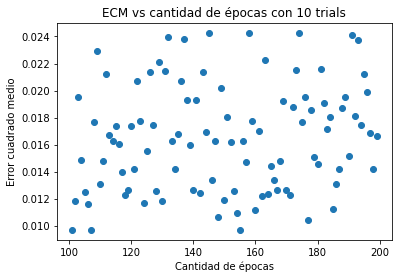

In [12]:
# Making a scatterplot showing n_epochs and MSE
plt.scatter(list(epochs_mse.keys()), list(epochs_mse.values())) # The first few values were pretty bad
plt.title('ECM vs cantidad de épocas con 10 trials')
plt.xlabel('Cantidad de épocas')
plt.ylabel('Error cuadrado medio')
plt.show()

In [13]:
# Selecting and testing the top 10 n_epochs
top_10_n_epochs = dict(sorted(epochs_mse.items(), key = itemgetter(1))[:10])
top_10_n_epochs = list(top_10_n_epochs)
top_10_mse, top_10_hyperpar = try_n_epochs(top_10_n_epochs, 50) 

Study for 101 epochs finished
Study for 155 epochs finished
Study for 107 epochs finished
Study for 177 epochs finished
Study for 148 epochs finished
Study for 154 epochs finished
Study for 160 epochs finished
Study for 185 epochs finished
Study for 106 epochs finished
Study for 124 epochs finished


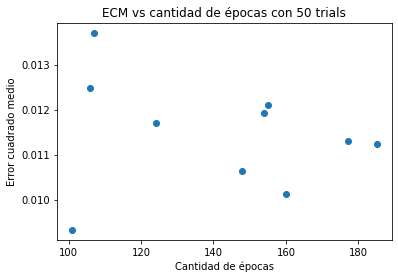

In [14]:
# Making a scatterplot showing n_epochs and MSE
plt.scatter(list(top_10_mse.keys()), list(top_10_mse.values()))
plt.title('ECM vs cantidad de épocas con 50 trials')
plt.xlabel('Cantidad de épocas')
plt.ylabel('Error cuadrado medio')
plt.show()

In [15]:
# Searching deeper with the best n_epochs
best_n_epochs = dict(sorted(top_10_mse.items(), key = itemgetter(1))[:1])
best_n_epochs = list(best_n_epochs)
best_n_epochs_mse, best_n_epochs_hyperpar =  try_n_epochs(best_n_epochs, 250)

Study for 101 epochs finished


In [16]:
# Printing the hyperparameters of the best model
best_n_epochs = list(best_n_epochs_mse.keys())[0]
print(f'The best model found was trained over {best_n_epochs} epochs')
print(f'The MSE of the model was {best_n_epochs_mse[best_n_epochs]}')
print(f'The hyperparameters of the models are:')
for key, value in best_n_epochs_hyperpar[best_n_epochs]:
            print(f"    {key}: {value}")

The best model found was trained over 101 epochs
The MSE of the model was 0.00888122245669365
The hyperparameters of the models are:
    n_layers: 2
    layer_width_0: 32
    act_function_0: Sigmoid
    dropout_layer_0: 0.2171436146744279
    layer_width_1: 15
    act_function_1: Sigmoid
    dropout_layer_1: 0.045947471197379845
    init_w: normal_
    optimizer: Adam
    lr: 0.10914867837932948
    weight_decay: 0.0


## Validacion del modelo
### Extrayendo los hiperparametros resultantes de la seleccion

In [17]:
# Getting the model hyperparameters
def get_optim_init_hyperparams(best_n_epochs_hyperpar):
    """This function reads the hyperparameters for weight initialization
       and optimizer"""
    # Getting n_epochs
    n_epochs = list(best_n_epochs_hyperpar.keys())[0]

    # Looping over the hyperparams
    for key, value in best_n_epochs_hyperpar[n_epochs]:
        # Find the init weights
        if key == 'init_w':
            init_w = value
        # Find the optim algo
        if key == 'optimizer':
            optimizer = value
        # Find the learning rate
        if key == "lr":
            lr = value
        # Find weight decay
        if key == 'weight_decay':
            weight_decay = value

    return init_weights, optimizer, lr, weight_decay

def get_model_arch(best_n_epochs_hyperpar):
    """This function reads the architechture of the model itself"""
    # Getting n_epochs
    n_epochs = list(best_n_epochs_hyperpar.keys())[0]

    # Looping over the hyperparams
    for key, value in best_n_epochs_hyperpar[n_epochs]:
        # Find n_layers
        if key == 'n_layers':
            n_layers = value

    # Creating lists for the layer related hyperparams
    width_list = [0 for i in range(n_layers)]
    act_func_list = [0 for i in range(n_layers)]
    dropout_list = [0 for i in range(n_layers)]        

    # Looping over the hyperparams
    for key, value in best_n_epochs_hyperpar[n_epochs]:
        
        # Find the width of each layer
        if re.match('layer_width_(\d)+', key):
            # If layer number has a single digit
            if len(key) == 13:
                i = int(key[-1:])
                width_list[i] = value
            # If layer number has two digits
            if len(key) == 14:
                i = int(key[-2:])
                width_list[i] = value

        # Find the activation function of each layer
        if re.match('act_function_(\d)+', key):
            # If layer number has a single digit
            if len(key) == 14:
                i = int(key[-1:])
                act_func_list[i] = value
            # If layer number has two digits
            if len(key) == 15:
                i = int(key[-2:])
                act_func_list[i] = value

        # Find the dropout for each layer
        if re.match('dropout_layer_(\d)+', key):
            # If layer number has a single digit
            if len(key) == 15:
                i = int(key[-1:])
                dropout_list[i] = value
            # If layer number has two digits
            if len(key) == 16:
                i = int(key[-2:])
                dropout_list[i] = value

    return n_layers, width_list, act_func_list, dropout_list

# Getting the hyperparams
init_w, optim, lr, w_decay = get_optim_init_hyperparams(best_n_epochs_hyperpar)
n_layers, width_list, act_func_list, dropout_list = get_model_arch(best_n_epochs_hyperpar)
n_epochs = list(best_n_epochs_hyperpar.keys())[0]


### Funciones para definir el modelo

In [18]:
def define_final_model(in_feat, n_layers, width_list, act_function_list, dropout_list):
    """This funtion makes the structure of the model from the optimized 
       hyperparams"""
    layers = []
    
    for i in range(n_layers):
        layers.append(nn.Linear(in_feat, width_list[i]))
        layers.append(getattr(nn, act_function_list[i])())
        layers.append(nn.Dropout(dropout_list[i]))
        in_feat = width_list[i]

    layers.append(nn.Linear(in_feat, 1))
    model = nn.Sequential(*layers)
    return model

def final_init_weights(model, init_w):
    """This function initializes the model's weights"""
    if model == nn.RNN:
        getattr(nn.init, init_w)(model.weight, mean=0, std=0.01)
        nn.init.zeros_(model.bias)

def get_final_optim(model, optimizer, lr, weight_decay):
    optim = getattr(torch.optim, optimizer)(model.parameters(), lr, weight_decay=weight_decay)
    return optim

### Construyendo los datasets para validar el modelo

In [19]:
# Arranging the data for 5 fold cross-val
def k_fold_split(k, X, y):
    """This function splits the data in k-folds respecting time order"""
    # This list will contain tuples that contain the tensors with the data
    cross_val_list = []
    # Making a list that counts down from k to 1
    k_list = [i for i in range(1, k+1)][::-1]
    # Looping over the values in the list
    for i in k_list:
        # Calculating the final row of the validation set
        val_row = int(round(X.shape[0]/i, 0))
        # Calculating the final row of the train set
        train_row = int(round(val_row*0.8, 0))
        # Making the features and labels for the fold
        X_train, X_val =  X[:train_row], X[train_row:val_row]
        y_train, y_val = y[:train_row], y[train_row:val_row]
        # Transforming the numpy arrays to tensors
        X_train, X_val = torch.from_numpy(X_train), torch.from_numpy(X_val)
        y_train, y_val = torch.from_numpy(y_train), torch.from_numpy(y_val)
        # Appending the tuple of tensors to the list
        cross_val_list.append((X_train, X_val, y_train, y_val))
    return cross_val_list
k = 5
folded_data = k_fold_split(k, X, y)

### Validando el modelo

In [20]:
# Performing the cross validation

# Accumulators for the train and validation error
train_mse_sum = 0
val_mse_sum = 0

# List for the model predictions
preds_list = []

# Looping over the folds
for i in range(len(folded_data)):
    # Define the model
    torch.manual_seed(10) # Set the seed
    model = define_final_model(X.shape[1], n_layers, width_list, act_func_list, dropout_list)
    final_init_weights(model, init_w) # Init weights
    optimizer = get_final_optim(model, optim, lr, w_decay) # Optimizer 
    # Get the training and validation data
    X_train, y_train = folded_data[i][0], folded_data[i][2]
    train_data = load_data((X_train, y_train), batch_size)
    X_val, y_val = folded_data[i][1], folded_data[i][3]
    val_data = load_data((X_val, y_val), batch_size)
    # Training
    train_model(optimizer, model, train_data, nn.MSELoss(), n_epochs) 
    # Calculating the mse over the training set
    train_mse = test_model(model, train_data) # This function also works for the training data
    # Getting the model predictions over the training set
    y_train_pred = get_model_preds(model, X_train) 
    # Calculating the mse over the validation set
    val_mse = test_model(model, val_data)
    # Getting the model predictions over the validation set
    y_val_pred = get_model_preds(model, X_val) 
    # Adding to the accumulators
    train_mse_sum += train_mse
    val_mse_sum += val_mse
    # Adding the predictions to the list
    preds_list.append((y_train_pred, y_val_pred))
    # Printing data
    print(f'Finished the fold number {i+1}, train mse: {train_mse}, val mse: {val_mse}')
    
# Calculating and printing averages
avg_train_mse = train_mse_sum / len(folded_data)
avg_val_mse = val_mse_sum / len(folded_data)
print(f'Average train mse was: {avg_train_mse}')
print(f'Average validation mse was: {avg_val_mse}')

Finished the fold number 1, train mse: 0.014475754462182522, val mse: 0.003924792632460594
Finished the fold number 2, train mse: 0.01367898378521204, val mse: 0.0008261636830866337
Finished the fold number 3, train mse: 0.012062414549291134, val mse: 0.02454620786011219
Finished the fold number 4, train mse: 0.011154635809361935, val mse: 0.00902547501027584
Finished the fold number 5, train mse: 0.009778924286365509, val mse: 0.01070431713014841
Average train mse was: 0.012230142578482628
Average validation mse was: 0.009805391263216733


### Graficando los resultados de la validación

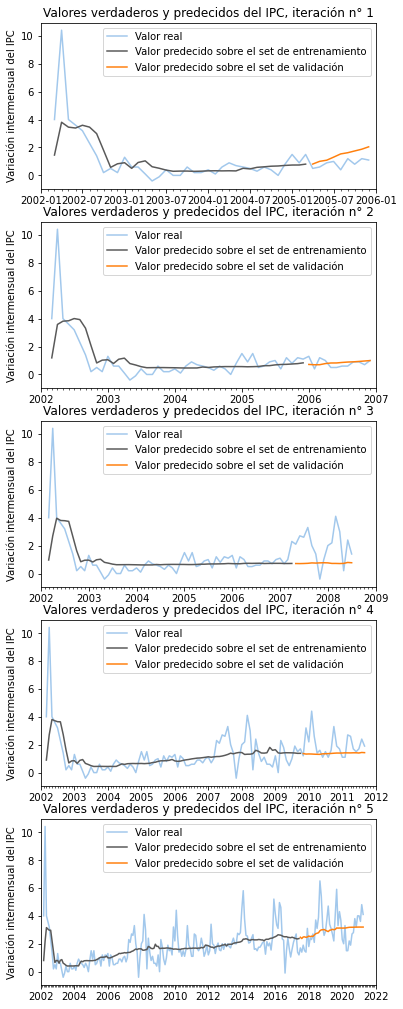

In [21]:
# Plotting the results of the model validation

fig = plt.figure(figsize=[6, 17.7])
# Looping over each fold
for i in range(k):
    # Getting the predicted values 
    y_pred_train = ipc_scaler.inverse_transform(preds_list[i][0].numpy())
    y_pred_val = ipc_scaler.inverse_transform(preds_list[i][1].numpy())
    # Getting the true values
    y_true = torch.cat((folded_data[i][2], folded_data[i][3]), dim=0).numpy()
    y_true = ipc_scaler.inverse_transform(y_true)
    # Calculating the period for the train and validation set
    train_period = data['fecha'][:y_pred_train.shape[0]]
    val_period = data['fecha'][y_pred_train.shape[0]:y_pred_train.shape[0]+y_pred_val.shape[0]]
    # Adding a plot to the figure and plotting
    ax = fig.add_subplot(k, 1, i+1)
    line_1 = ax.plot(data['fecha'][:y_true.shape[0]], y_true, c=(162/255, 200/255, 236/255), 
                     label='Valor real') 
    line_2 = ax.plot(train_period, y_pred_train, c=(89/255, 89/255, 89/255), 
                     label='Valor predecido sobre el set de entrenamiento')
    line_3 = ax.plot(val_period, y_pred_val, c=(255/255, 128/255, 14/255),
                     label='Valor predecido sobre el set de validación')   
    # Minor ticks every month.
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(fmt_month)
    # Round to nearest years.
    datemin = np.datetime64(data['fecha'][0], 'Y')
    datemax = np.datetime64(data['fecha'][y_true.shape[0]-1], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)
    # Format data
    ax.format_xdata = mdates.DateFormatter('%m/%Y')
    # Set title and ylabel
    ax.set_title(f'Valores verdaderos y predecidos del IPC, iteración n° {i+1}')
    ax.set_ylabel('Variación intermensual del IPC')
    # Setting up the legend
    ax.legend(loc='upper right')

plt.savefig('five_fold_val.jpeg', bbox_inches = 'tight')
plt.show()

### Calculando el ECM promedio no normalizado

In [22]:
# Accumulators for the MSE
train_mse_sum = 0.0
val_mse_sum = 0.0
for i in range(k):
    # Getting the predicted values 
    y_pred_train = ipc_scaler.inverse_transform(preds_list[i][0].numpy())
    y_pred_val = ipc_scaler.inverse_transform(preds_list[i][1].numpy())
    # Getting the true values
    y_true = torch.cat((folded_data[i][2], folded_data[i][3]), dim=0).numpy()
    y_true = ipc_scaler.inverse_transform(y_true)
    # Getting the true values for the train and validation sets
    y_true_train = y_true[:y_pred_train.shape[0]]
    y_true_val = y_true[y_pred_train.shape[0]:]
    # Calculating the MSE for the train and validation sets
    train_mse = np.square(y_pred_train - y_true_train).mean()
    val_mse = np.square(y_pred_val - y_true_val).mean()
    # Adding to the accumulators
    train_mse_sum += train_mse
    val_mse_sum += val_mse

print(f'Average train non normalized mse was: {train_mse_sum/k}')
print(f'Average validation non normalized mse was: {val_mse_sum/k}')

Average train non normalized mse was: 1.4265237331390381
Average validation non normalized mse was: 1.1437007322907449


## Entrenando el modelo sobre todo el dataset y guardando los parametros

In [23]:
# Defining the data to train the model
X = torch.from_numpy(X)
y = torch.from_numpy(y)

# Defining the model, init weights and optimizer, and training
torch.manual_seed(10) # Set the seed
model = define_final_model(X.shape[1], n_layers, width_list, act_func_list, dropout_list)
final_init_weights(model, init_w)
optimizer = get_final_optim(model, optim, lr, w_decay)
train_model(optimizer, model, train_data, nn.MSELoss(), n_epochs)

# Saving the model and optimizer params
torch.save(model.state_dict(), './model-params')
torch.save(optimizer.state_dict(), './optim-params')